<a href="https://colab.research.google.com/github/Rivallis/Notes/blob/master/csc2541_presentation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description

**Notebook By: Alex Adam, Jenny Liu, and Keiran Paster**

This work was done as part of the course [CSC2541 Topics in Machine Learning:
Neural Net Training Dynamics](https://www.cs.toronto.edu/~rgrosse/courses/csc2541_2021/) taught by [Roger Grosse](https://www.cs.toronto.edu/~rgrosse/). It implements some experiments similar to those done in the paper: [Understanding Black-box Predictions via Influence Functions](https://arxiv.org/pdf/1703.04730.pdf) by Pang Wei Koh and Percy Liang

We look at the following use cases of Influence Functions

1. Identifying training points which are important/deterimental for the correct prediction on a test point $z_{\mathrm{test}}$
2. Comparing LOO training vs. the estimated influence of a training point on the loss for $z_{\mathrm{test}}$.
3. Using Influence Functions to identify noisy samples

**A Note on Model Capacity**

The parameters/solution being analyzed are extremely important for the validity of the Influence computation. Namely, a high capacity model that is not regularized could easily overfit the small datasets we are considering here. This would make the term $\nabla_{\theta} L(x_{\mathrm{train}}, y_{\mathrm{train}}) \approx 0$ making the influence of any training point on a given test point be 0. Since the authors mention that $\theta$ should be the empirical risk minimizer (convex objective with unique solution), this raises questions about whether it makes sense to even compute Influence for models trained with early stopping.

# Initialization

In [ ]:
import jax
import jax.numpy as np
import random

from jax.flatten_util import ravel_pytree

import numpy as onp
import torch
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons, make_blobs
from scipy.stats import pearsonr
%matplotlib inline

## Define Data


In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    onp.random.seed(seed)
    random.seed(seed)

In [ ]:
def create_moons_data(n, noise=0.0):
    return make_moons(n, noise=noise)

In [ ]:
def create_blobs_data(n):
    x, y = make_blobs(n, 2, np.array([[0.0, 0.0], [2.0, 2.0]]), cluster_std=0.8)

    x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
    return x, y

In [ ]:
set_seed(2)
x_blob, y_blob = create_blobs_data(200)
x_moon, y_moon = create_moons_data(200, noise=0.05)

data = {"moon": {"x": x_moon, "y": y_moon},
        "blob": {"x": x_blob, "y": y_blob}}

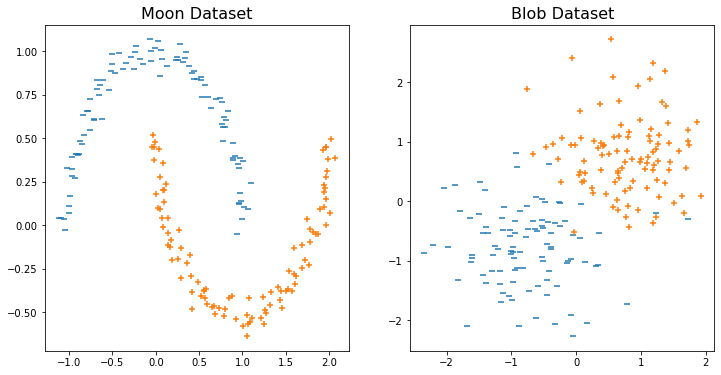

In [ ]:
fig = plt.figure(figsize=(len(data) * 6, 6))

for i, data_type in enumerate(data.keys()):
    x, y = data[data_type]["x"], data[data_type]["y"]

    ax = fig.add_subplot(1, len(data), i + 1)
    ax.scatter(x[:, 0][y == 0], x[:, 1][y == 0], marker="_")
    ax.scatter(x[:, 0][y == 1], x[:, 1][y == 1], marker="+")
    ax.set_title("{} Dataset".format(data_type.capitalize()), size=16)



## Define Model

In [ ]:
eps = 1e-6

In [ ]:
def relu(x):
    return np.clip(x, 0, np.max(x) + 1)

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
def network(params, x):
    w1, b1, w2, b2 = params
    hidden = np.tanh(np.dot(w1, x) + b1)

    return np.dot(w2, hidden) + b2

In [ ]:
def stable_loss(params, x, y):
    out = network(params, x)
    ce = y * np.logaddexp(0, -out) + (1 - y) * np.logaddexp(0, out)

    return ce


In [ ]:
def loss(params, x, y):
    out = network(params, x)
    # print(out)
    # out = np.clip(out, eps, 1 - eps)
    # out = sigmoid(out)

    ce = -y * np.log(out) - (1 - y) * np.log(1 - out)

    return ce

In [ ]:
def initialize_params():
    set_seed(2)

    return [
    onp.random.randn(100, 2),  # w1
    onp.random.randn(100),  # b1
    onp.random.randn(100),  # w2
    onp.random.randn(),  #b2
    ]

In [ ]:
def flat_network(flat_params, unflattener, x):
    w1, b1, w2, b2 = unflattener(flat_params)

    hidden = np.tanh(np.dot(w1, x) + b1)

    return np.dot(w2, hidden) + b2

In [ ]:
def flat_loss(flat_params, unflattener, x, y):
    out = flat_network(flat_params, unflattener, x)

    # ce = -y * np.log(out) - (1 - y) * np.log(1 - out)
    ce = y * np.logaddexp(0, -out) + (1 - y) * np.logaddexp(0, out)

    return ce

In [ ]:
def empirical_risk(flat_params, unflattener, x, y):
    total_loss = 0

    for i in range(len(x)):
        l = flat_loss(flat_params, unflattener, x[i], y[i])
        total_loss += l

    return total_loss / len(x)

## Train Model

In [ ]:
params = {data_type: initialize_params() for data_type in data.keys()}

In [ ]:
loss_grad = jax.jit(jax.vmap(jax.value_and_grad(stable_loss), in_axes=(None, 0, 0), out_axes=0))

In [ ]:
lr = 10.0

In [ ]:
epochs = 10000

In [ ]:
stable_loss(params["moon"], x[0], y[0])

DeviceArray(8.3975897e-07, dtype=float32)

In [ ]:
loss(params["moon"], x[0], y[0])

DeviceArray(nan, dtype=float32)

In [ ]:
for data_type in data.keys():
    print("Now training on {} dataset".format(data_type))
    x, y = data[data_type]["x"], data[data_type]["y"]

    for epoch in range(epochs):
        values, grads = loss_grad(params[data_type], x, y)

        if np.any(np.isnan(values)):
            print("One of the loss values is NaN. Stopping optimization")
            break
        params[data_type] = [param - lr * np.mean(grad, axis=0) for param, grad in zip(params[data_type], grads)]

        if epoch % 1000 == 0:
            print("Loss: {}".format(np.mean(values)))

Now training on moon dataset
Loss: 3.805375337600708
Loss: 1.0188998658122728e-06
Loss: 5.165904326531745e-07
Loss: 3.4947649396599445e-07
Loss: 2.6621589199748996e-07
Loss: 2.1666180316515238e-07
Loss: 1.8389472700164333e-07
Loss: 1.6081182252492e-07
Loss: 1.4351560650993633e-07
Loss: 1.3031353773840237e-07
Now training on blob dataset
Loss: 0.200153186917305
Loss: 0.03162016719579697
Loss: 0.017498653382062912
Loss: 0.0009612027206458151
Loss: 0.0005451179458759725
Loss: 0.00037389787030406296
Loss: 0.00028084329096600413
Loss: 0.00022286792227532715
Loss: 0.00018352271581534296
Loss: 0.0001552001340314746


Check model output


In [ ]:
out_fn = jax.vmap(network, in_axes=[None, 0], out_axes=0)

In [ ]:
for data_type in data.keys():
    out = sigmoid(out_fn(params[data_type], data[data_type]["x"]))
    pred = np.round(out)

    acc = np.sum(pred ==  data[data_type]["y"]) / float(len( data[data_type]["y"]))
    print("Accuracy on {} data: {}".format(data_type, acc))

Accuracy on moon data: 1.0
Accuracy on blob data: 1.0


# Basic Influence Visualization

To compute the influence of upweighting a given training point $x_{\mathrm{train}}$ on some test point $x_{\mathrm{test}}$, we compute $I_{(\mathrm{up}, \mathrm{loss})}(z, z_{\mathrm{test}}) = - \nabla_{\theta} L(x_{\mathrm{test}}, y_{\mathrm{test}})^{\top} H^{-1}_{\theta} \nabla_{\theta} L(x_{\mathrm{train}}, y_{\mathrm{train}})$ where $H^{-1}_{\theta} = \frac{1}{N} \sum_{i=1}^{N} \nabla^{2}_{\theta} L(x_{i}, y_{i})$

This can be broken up into a HIVP followed by a dot product. Note the inverse on the Hessian which adds an extra step. In the paper, a stochastic second-order method is used called LiSSA which iteratively computes a series whose limit is the Hessian inverse. The convergence of that algorithm was not satisfactory, and it had a few hyperparameters to set. Since the model and dataset we're dealing with are both small, we can exactly compute the Hessian and its inverse.

## Compute $s_{\mathrm{test}} = H^{-1}_{\theta}\nabla_{\theta} L(x_{\mathrm{test}}, y_{\mathrm{test}})$

### Importance of Flattening Parameters

Recall that `params` is just a list containing our $4$ individual weight matrices and bias vectors: $[w_{1}, b_{1}, w_{2}, b_{2}]$.

Without flattening parameters, `jax.grad` would return a list of gradients $[ \nabla_{w_{1}} L(x, y), \nabla_{b_{1}} L(x, y), \nabla_{w_{2}} L(x, y), \nabla_{b_{2}} L(x, y)]$ each with shape corresponding to parameter shape.

`jax.hessian` would return a pytree which can be thought of as a list of lists in this example. At index $h[1][0]$, we have $\nabla_{w_{1}} \nabla_{b_{1}} L(x, y)$ and at index $h[3][3]$ we have $\nabla^{2}_{b_{2}} L(x, y)$. Computing HVPs in this tree format gets hairy, so we flatten everything to get a single parameters vector $\theta$ such that $\nabla_{\theta} L(x,y) \in \mathbb{R}^{P}$ and $\nabla^{2}_{\theta} L(x,y) \in \mathbb{R}^{P \times P}$.

In [ ]:
test_points = {"moon": {"x": np.array([-1.0, 1.]),
                        "y": np.array(0.0)},
               "blob": {"x": np.array([-1.0, 1.]),
                        "y": np.array(0.0)}}

In [ ]:
test_losses = {data_type: stable_loss(params[data_type],
                               test_points[data_type]["x"],
                               test_points[data_type]["y"]) for data_type in data.keys()}

In [ ]:
flattened_params = {data_type: {"params": ravel_pytree(params[data_type])[0],
                                "unflattener": ravel_pytree(params[data_type])[1]} for data_type in params.keys()}

In [ ]:
train_losses = {data_type: 0.0 for data_type in data.keys()}
vs = {data_type: None for data_type in data.keys()}
hessians = {data_type: None for data_type in data.keys()}
inv_hessians = {data_type: None for data_type in data.keys()}
s_tests = {data_type: {} for data_type in data.keys()}

for data_type in data.keys():
    flat_params, unflattener = flattened_params[data_type]["params"], flattened_params[data_type]["unflattener"]
    x, y = data[data_type]["x"], data[data_type]["y"]
    x_test, y_test = test_points[data_type]["x"], test_points[data_type]["y"]

    train_loss = empirical_risk(flat_params, unflattener, x, y)
    v = jax.grad(flat_loss)(flat_params, unflattener, x_test, y_test)
    hess = jax.hessian(empirical_risk)(flat_params, unflattener, x, y)
    inv_hess = onp.linalg.inv(hess)

    s_test_orig = onp.sum(inv_hess * v, axis=1)
    s_test_no_inv = onp.sum(hess * v, axis=1)

    train_losses[data_type] = train_loss
    vs[data_type] = v
    hessians[data_type] = hess
    inv_hessians[data_type] = inv_hess
    s_tests[data_type]["orig"] = s_test_orig
    s_tests[data_type]["no_inv"] = s_test_no_inv

## Compute $I_{(\mathrm{up}, \mathrm{loss})}(z_{\mathrm{train}}, z_{\mathrm{test}}) = -s_{\mathrm{test}} \cdot \nabla_{\theta} L(x_{\mathrm{train}}, y_{\mathrm{train}})$

Note that $I_{(\mathrm{up}, \mathrm{loss})}(z_{\mathrm{train}}, z_{\mathrm{test}})$ measures the effect of **upweighting** $z_{\mathrm{train}}$. Section 2.1 of the paper mentions that to measure the effect of removing $z_{\mathrm{train}}$ from the training data, we should multiply by $-\frac{1}{N}$. The convention we should stick with is that so-called "bad" points should be the ones that if removed would decrease the loss, and "good" points should be the ones that if removed would increase the loss.

In [ ]:
influence_types = ["orig", "no_inv", "linear"]
influences = {data_type: {influence_type: [0.0] * len(data[data_type]["x"]) for influence_type in influence_types} for data_type in data.keys()}

for data_type in data.keys():
    flat_params, unflattener = flattened_params[data_type]["params"], flattened_params[data_type]["unflattener"]
    x, y = data[data_type]["x"], data[data_type]["y"]

    for i in range(len(x)):
        grad_x_i = jax.grad(flat_loss)(flat_params, unflattener, x[i], y[i])

        influences[data_type]["orig"][i] = - onp.vdot(s_tests[data_type]["orig"], grad_x_i)
        influences[data_type]["no_inv"][i] = - onp.vdot(s_tests[data_type]["no_inv"], grad_x_i)
        influences[data_type]["linear"][i] = -onp.vdot(v, grad_x_i)

In [ ]:
influences = {data_type: {influence_type: np.array(influences[data_type][influence_type]) *
                          (-1.0 * len(influences[data_type][influence_type])) for influence_type in influence_types} for data_type in influences.keys()}

In [ ]:
influential_points = {data_type: {influence_type: onp.array(np.argsort(influences[data_type][influence_type])) for influence_type in influence_types} for data_type in influences.keys()}

## Visualize Influential Points

In [ ]:
xxs, yys = {}, {}
Zs = {}

In [ ]:
for data_type in data.keys():
    x, y = data[data_type]["x"], data[data_type]["y"]
    x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
    y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5
    xx, yy = onp.meshgrid(onp.arange(x_min, x_max, 0.01),
                            onp.arange(y_min, y_max, 0.01))

    temp = jax.vmap(network, in_axes=(None, 0), out_axes=0)

    Z = temp(params[data_type], onp.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    xxs[data_type] = xx
    yys[data_type] = yy
    Zs[data_type] = Z

In [ ]:
title_mapping = {"orig": "With Inverse", "no_inv": "Without Inverse", "linear": "Linear"}

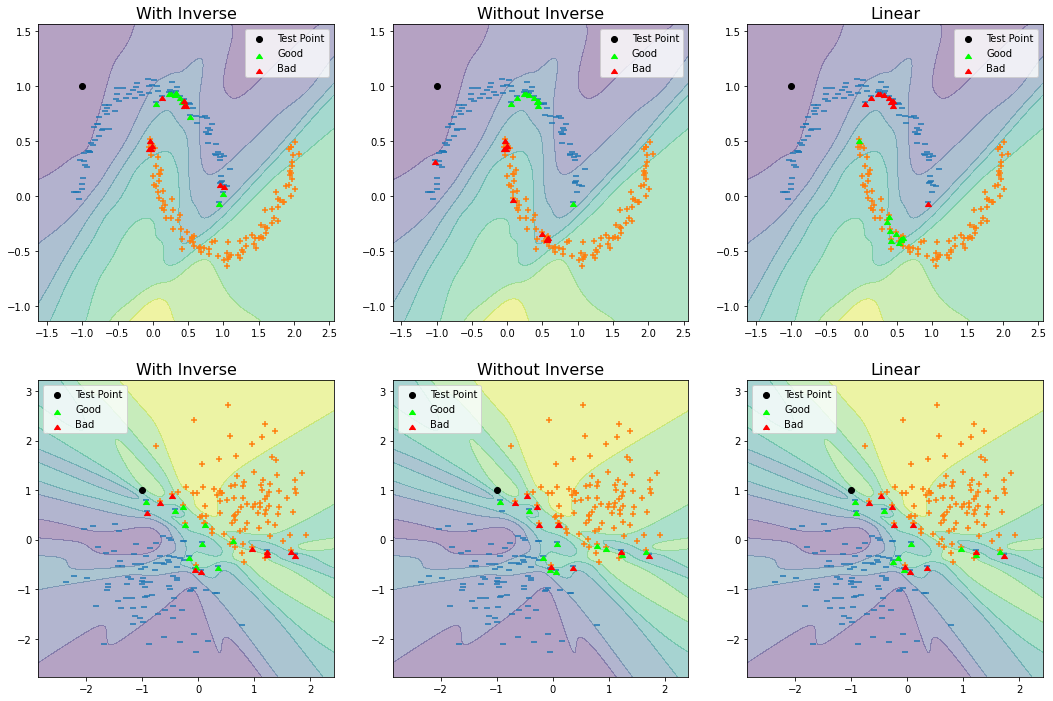

In [ ]:
fig = plt.figure(figsize=(len(influence_types) * 6, len(data) * 6))

for i, data_type in enumerate(data.keys()):
    x, y = data[data_type]["x"], data[data_type]["y"]
    x_test, y_test = test_points[data_type]["x"], test_points[data_type]["y"]
    xx, yy, Z = xxs[data_type], yys[data_type], Zs[data_type]

    for j, influence_type in enumerate(influence_types):
        ax = fig.add_subplot(len(data), len(influence_types), (i) * len(influence_types) + (j + 1))
        ax.contourf(xx, yy, Z, alpha=0.4)
        ax.scatter(x[:, 0][y == 0], x[:, 1][y == 0], marker="_")
        ax.scatter(x[:, 0][y == 1], x[:, 1][y == 1], marker="+")
        ax.scatter(x_test[0], x_test[1], c="black", label="Test Point")
        ax.scatter(x[influential_points[data_type][influence_type][-10:], 0], x[influential_points[data_type][influence_type][-10:], 1], c="lime", marker=6, label="Good")
        ax.scatter(x[influential_points[data_type][influence_type][:10], 0], x[influential_points[data_type][influence_type][:10], 1], c="red", marker=6, label="Bad")
        ax.set_title(title_mapping[influence_type], size=16)
        ax.legend()


In [ ]:
s_tests["moon"]["orig"]

DeviceArray([ 8.59095774e-19, -6.34089774e-19,  5.63740390e-21,
             -1.47751906e-21, -1.33043600e-21,  4.25416404e-22,
             -4.95890435e-22, -3.83808093e-22,  2.51788722e-20,
             -3.00101288e-20,  9.87511480e-23,  4.90793157e-23,
             -4.78429487e-17, -6.66942427e-17, -1.33812418e-22,
             -7.46707208e-23,  4.28577528e-23,  2.62434459e-23,
             -3.28356647e-20,  2.31743777e-20, -1.41589218e-21,
             -2.54168187e-21,  3.13570317e-23, -2.10780352e-23,
             -4.68090119e-22,  3.14453841e-22,  9.89307599e-19,
             -7.53929737e-19, -2.29485751e-21,  1.12589621e-21,
              2.09386555e-22,  8.14986969e-22, -6.34023600e-21,
              3.01007794e-21, -1.50932027e-21,  5.95595890e-22,
              8.69301872e-23,  5.32820321e-23, -3.56755970e-23,
              3.08942669e-23, -3.03648490e-19, -3.43388392e-19,
              2.14564899e-20, -3.69559838e-20, -8.07705679e-21,
              4.94421362e-21,  7.8547261

## Comparison With Conjugate Gradient

In our above computation of $s_{\mathrm{test}}$, we naively computed the full Hessian, and explicitly inverted the matrix. Here we look at using CG to compute the HIVP

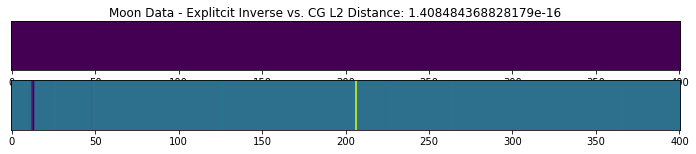

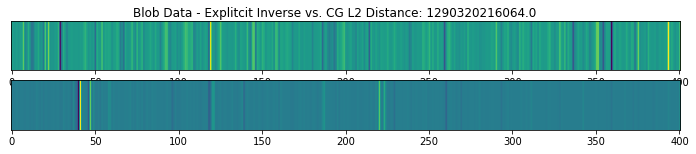

In [ ]:
for data_type in hessians.keys():
    s_test_cg = jax.scipy.sparse.linalg.cg(hessians[data_type], vs[data_type])[0]
    s_test_orig = s_tests[data_type]["orig"]

    difference = onp.linalg.norm(s_test_orig - s_test_cg, ord=2)

    fig = plt.figure(figsize=(12, 2))

    ax = fig.add_subplot(211)
    ax.imshow(s_test_cg[onp.newaxis], aspect="auto")
    ax.set_yticks([])

    ax = fig.add_subplot(212)
    ax.imshow(s_test_orig[onp.newaxis], aspect="auto")
    ax.set_yticks([])

    fig.suptitle("{} Data - Explitcit Inverse vs. CG L2 Distance: {}".format(data_type.capitalize(), difference))

# Retrain Without Important Points

In [ ]:
def fit(x, y):
    set_seed(2)

    loss_grad = jax.jit(jax.vmap(jax.value_and_grad(loss), in_axes=(None, 0, 0), out_axes=0))
    lr = 0.25
    params = initialize_params()
    epochs = 10000

    for epoch in range(epochs):
        values, grads = loss_grad(params, new_x, new_y)
        params = [param - lr * np.mean(grad, axis=0) for param, grad in zip(params, grads)]

        if np.mean(values) < 0.01:
            break
        if epoch % 1000 == 0:
            print("Loss: {}".format(np.mean(values)))

    return params

In [ ]:
num_points = 10

In [ ]:
actual_diffs = {data_type: [] for data_type in data.keys()}

for data_type in data.keys():
    print("Now training on {} dataset".format(data_type))
    x, y = data[data_type]["x"], data[data_type]["y"]

    for i in range(num_points):
        idx = influential_points[data_type]["orig"][i]

        new_x, new_y = np.concatenate([x[:idx], x[idx + 1:]]), np.concatenate([y[:idx], y[idx + 1:]])

        temp_params = fit(x, y)

        temp_loss = loss(temp_params, x_test, y_test)
        actual_diffs[data_type].append(temp_loss - test_losses[data_type])

Now training on moon dataset
Loss: 1.7845227718353271
Loss: 0.02091893181204796
Loss: 1.7645933628082275
Loss: 0.020797673612833023
Loss: 1.7844395637512207
Loss: 0.021199576556682587
Loss: 1.7823280096054077
Loss: 0.020620254799723625
Loss: 1.7843221426010132
Loss: 0.02126437984406948
Loss: 1.7843490839004517
Loss: 0.021314162760972977
Loss: 1.7843296527862549
Loss: 0.021332908421754837
Loss: 1.7758885622024536
Loss: 0.021007148548960686
Loss: 1.783931851387024
Loss: 0.021253881976008415
Loss: 1.7823630571365356
Loss: 0.021253671497106552
Now training on blob dataset
Loss: 0.3241124749183655
Loss: 0.06498739123344421
Loss: 0.060070790350437164
Loss: 0.05747637897729874
Loss: 0.05556091293692589
Loss: 0.05374370142817497
Loss: 0.05195227637887001
Loss: 0.05024542659521103
Loss: 0.048684172332286835
Loss: 0.04729520156979561
Loss: 0.32272645831108093
Loss: 0.06313198059797287
Loss: 0.05525883287191391
Loss: 0.05114731565117836
Loss: 0.047885674983263016
Loss: 0.045085109770298004
Loss: 

In [ ]:
actual_diffs = {data_type: onp.array(actual_diffs[data_type]) for data_type in actual_diffs.keys()}
pred_diffs_orig = {data_type: onp.array(influences[data_type]["orig"][influential_points[data_type]["orig"][:num_points]]) for data_type in actual_diffs.keys()}
pred_diffs_no_inv = {data_type: onp.array(influences[data_type]["no_inv"][influential_points[data_type]["no_inv"][:num_points]]) for data_type in actual_diffs.keys()}

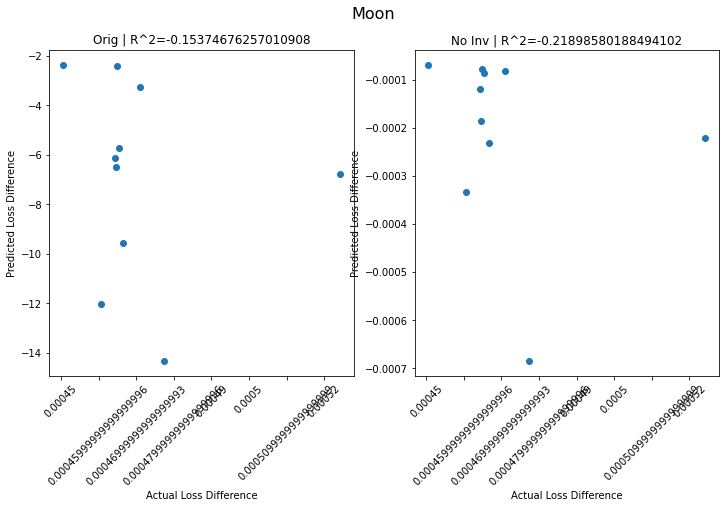

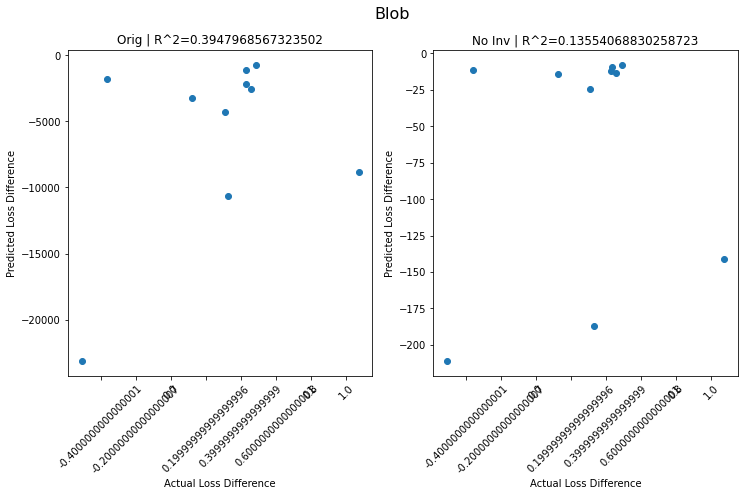

In [ ]:
for data_type in actual_diffs.keys():
    actual_diff = actual_diffs[data_type]
    pred_diff_orig = pred_diffs_orig[data_type]
    pred_diff_no_inv = pred_diffs_no_inv[data_type]

    r2_orig = pearsonr(actual_diff, pred_diff_orig)[0]
    r2_no_inv = pearsonr(actual_diff, pred_diff_no_inv)[0]

    fig = plt.figure(figsize=(12,6))

    ax = fig.add_subplot(121)
    ax.scatter(actual_diff, pred_diff_orig)
    ax.set_xlabel("Actual Loss Difference")
    ax.set_ylabel("Predicted Loss Difference")
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
    ax.set_title("Orig | R^2={}".format(r2_orig))

    ax = fig.add_subplot(122)
    ax.scatter(actual_diff, pred_diff_no_inv)
    ax.set_xlabel("Actual Loss Difference")
    ax.set_ylabel("Predicted Loss Difference")
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
    ax.set_title("No Inv | R^2={}".format(r2_no_inv))


    fig.suptitle("{}".format(data_type.capitalize()), size=16)

    plt.show()

# Identify Noisy Samples

Let's create a noisy version of the data used to fit the model previously. To do so, we randomly flip a certain percentage of the labels.

## Generate Noisy Data

In [ ]:
set_seed(2)
x_blob, y_blob = create_blobs_data(200)
x_moon, y_moon = create_moons_data(200, noise=0.1)

data_noisy = {"moon": {"x": x_moon, "y_clean": y_moon},
             "blob": {"x": x_blob, "y_clean": y_blob}}

In [ ]:
noise = 0.2

In [ ]:
for data_type in data_noisy.keys():
    y_noisy = data_noisy[data_type]["y_clean"].copy()
    x = data_noisy[data_type]["x"]

    noisy_indices = onp.random.choice(onp.arange(len(x)).astype(int), int(noise * len(x)), replace=False)
    y_noisy[noisy_indices] = 1 - y_noisy[noisy_indices]
    data_noisy[data_type]["y_noisy"] = y_noisy

## Train Model

In [ ]:
loss_grad = jax.jit(jax.vmap(jax.value_and_grad(loss), in_axes=(None, 0, 0), out_axes=0))
lr = 0.1
params_noisy = {data_type: initialize_params() for data_type in data_noisy.keys()}
epochs = 10000

In [ ]:
for data_type in data_noisy.keys():
    print("Now training on {} dataset".format(data_type))
    x, y = data_noisy[data_type]["x"], data_noisy[data_type]["y_noisy"]

    for epoch in range(epochs):
        values, grads = loss_grad(params_noisy[data_type], x, y)

        if np.any(np.isnan(values)):
            print("One of the loss values is NaN. Stopping optimization")
            break
        params_noisy[data_type] = [param - lr * np.mean(grad, axis=0) for param, grad in zip(params_noisy[data_type], grads)]

        if np.mean(values) < 0.05:
            break
        if epoch % 1000 == 0:
            print("Loss: {}".format(np.mean(values)))

Now training on moon dataset
Loss: 1.5655639171600342
Loss: 0.47599637508392334
Loss: 0.46623939275741577
Loss: 0.4623408317565918
Loss: 0.4599861800670624
Loss: 0.45780399441719055
Loss: 0.4555850923061371
Loss: 0.4531375765800476
Loss: 0.450236439704895
Loss: 0.44691169261932373
Now training on blob dataset
Loss: 0.7249340415000916
Loss: 0.5005522966384888
Loss: 0.49481400847435
Loss: 0.48815444111824036
Loss: 0.48316261172294617
Loss: 0.47929647564888
Loss: 0.4761747717857361
Loss: 0.4733611047267914
Loss: 0.47045236825942993
Loss: 0.4673668146133423


## Compute Losses

Like in the paper, we look at using loss to rank mislabeled samples as a baseline

In [ ]:
losses_noisy = {data_type: [] for data_type in data_noisy.keys()}

for data_type in data_noisy.keys():
    x, y = data_noisy[data_type]["x"], data_noisy[data_type]["y_noisy"]

    for i in range(len(x)):
        x_i, y_i = x[i], y[i]
        temp_loss = loss(params_noisy[data_type], x_i, y_i)
        losses_noisy[data_type].append(temp_loss)

In [ ]:
losses_noisy = {data_type: onp.array(losses_noisy[data_type]) for data_type in losses_noisy.keys()}

In [ ]:
influential_points_loss = {data_type: onp.argsort(losses_noisy[data_type])[::-1] for data_type in losses_noisy.keys()}

## Compute Influences


In [ ]:
flattened_params_noisy = {data_type: {"params": ravel_pytree(params_noisy[data_type])[0],
                                "unflattener": ravel_pytree(params_noisy[data_type])[1]} for data_type in params_noisy.keys()}

In [ ]:
train_losses_noisy = {data_type: 0.0 for data_type in data_noisy.keys()}
hessians_noisy = {data_type: None for data_type in data_noisy.keys()}
inv_hessians_noisy = {data_type: None for data_type in data_noisy.keys()}

for data_type in data_noisy.keys():
    flat_params, unflattener = flattened_params_noisy[data_type]["params"], flattened_params_noisy[data_type]["unflattener"]
    x, y = data_noisy[data_type]["x"], data_noisy[data_type]["y_noisy"]

    train_loss = empirical_risk(flat_params, unflattener, x, y)
    hess = jax.hessian(empirical_risk)(flat_params, unflattener, x, y)
    inv_hess = onp.linalg.inv(hess)

    train_losses_noisy[data_type] = train_loss
    hessians_noisy[data_type] = hess
    inv_hessians_noisy[data_type] = inv_hess

In [ ]:
influence_types = ["orig", "no_inv", "linear"]
influences_noisy = {data_type: {influence_type: [0.0] * len(data_noisy[data_type]["x"]) for influence_type in influence_types} for data_type in data_noisy.keys()}

for data_type in data_noisy.keys():
    flat_params, unflattener = flattened_params_noisy[data_type]["params"], flattened_params_noisy[data_type]["unflattener"]
    x, y = data_noisy[data_type]["x"], data_noisy[data_type]["y_noisy"]

    for i in range(len(x)):
        grad_x_i = jax.grad(flat_loss)(flat_params, unflattener, x[i], y[i])

        influences_noisy[data_type]["orig"][i] = - onp.vdot(onp.sum(inv_hessians_noisy[data_type] * grad_x_i, axis=1), grad_x_i)
        influences_noisy[data_type]["no_inv"][i] = - onp.vdot(onp.sum(hessians_noisy[data_type] * grad_x_i, axis=1), grad_x_i)
        influences_noisy[data_type]["linear"][i] = -onp.vdot(grad_x_i, grad_x_i)

In [ ]:
influences_noisy = {data_type: {influence_type: np.array(influences_noisy[data_type][influence_type]) *
                          (-1.0 * len(influences_noisy[data_type][influence_type])) for influence_type in influence_types} for data_type in influences_noisy.keys()}

In [ ]:
influential_points_noisy = {data_type: {influence_type: onp.array(np.argsort(influences_noisy[data_type][influence_type])) for influence_type in influence_types} for data_type in influences_noisy.keys()}

In [ ]:
for data_type in influential_points_noisy.keys():
    influential_points_noisy[data_type]["loss"] = influential_points_loss[data_type]

## Visualize Noisy Points

In [ ]:
xxs, yys = {}, {}
Zs = {}

In [ ]:
for data_type in data_noisy.keys():
    x, y = data_noisy[data_type]["x"], data_noisy[data_type]["y_noisy"]
    x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
    y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5
    xx, yy = onp.meshgrid(onp.arange(x_min, x_max, 0.01),
                            onp.arange(y_min, y_max, 0.01))

    temp = jax.vmap(network, in_axes=(None, 0), out_axes=0)

    Z = temp(params_noisy[data_type], onp.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    xxs[data_type] = xx
    yys[data_type] = yy
    Zs[data_type] = Z

In [ ]:
title_mapping = {"orig": "With Inverse", "no_inv": "Without Inverse", "linear": "Linear", "loss": "Loss"}

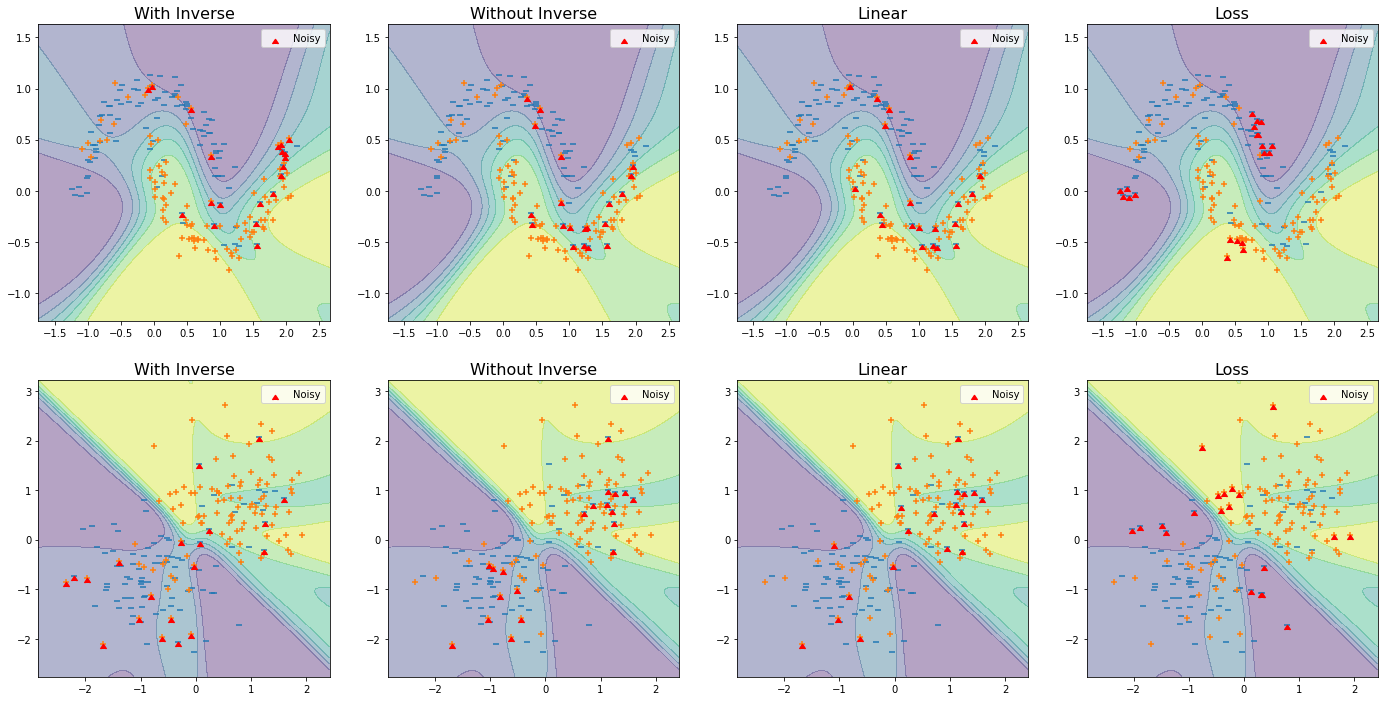

In [ ]:
fig = plt.figure(figsize=(len(title_mapping) * 6, len(data_noisy) * 6))

for i, data_type in enumerate(data_noisy.keys()):
    x, y = data_noisy[data_type]["x"], data_noisy[data_type]["y_noisy"]
    xx, yy, Z = xxs[data_type], yys[data_type], Zs[data_type]

    for j, influence_type in enumerate(influential_points_noisy[data_type].keys()):
        ax = fig.add_subplot(len(data_noisy), len(title_mapping), (i) * len(title_mapping) + (j + 1))
        ax.contourf(xx, yy, Z, alpha=0.4)
        ax.scatter(x[:, 0][y == 0], x[:, 1][y == 0], marker="_")
        ax.scatter(x[:, 0][y == 1], x[:, 1][y == 1], marker="+")

        ax.scatter(x[influential_points_noisy[data_type][influence_type][-20:], 0], x[influential_points_noisy[data_type][influence_type][-20:], 1], c="red", marker=6, label="Noisy")
        ax.set_title(title_mapping[influence_type], size=16)
        ax.legend()

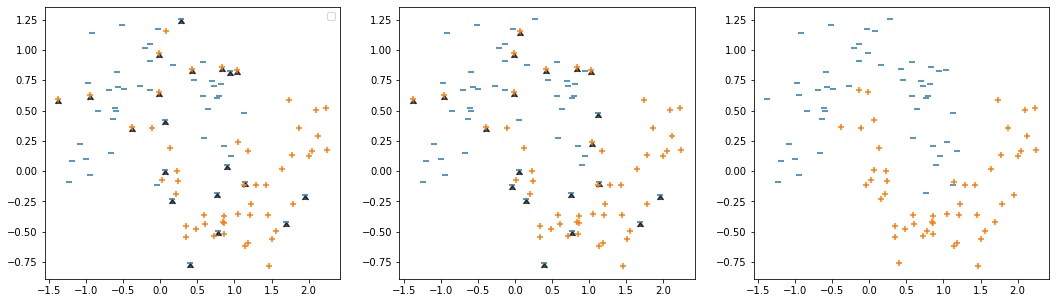

In [ ]:
fig = plt.figure(figsize=(18, 5))

ax = fig.add_subplot(131)
# ax.contourf(xx, yy, Z, alpha=0.4)
ax.scatter(x_noisy[:, 0][influential_points_train[:20]], x_noisy[:, 1][influential_points_train[:20]], marker=6, c="black", alpha=0.7)
ax.scatter(x_noisy[:, 0][y_noisy == 0], x_noisy[:, 1][y_noisy == 0], marker="_")
ax.scatter(x_noisy[:, 0][y_noisy == 1], x_noisy[:, 1][y_noisy == 1], marker="+")
ax.legend()

ax = fig.add_subplot(132)
ax.scatter(x_noisy[:, 0][influential_points_loss[:20]], x_noisy[:, 1][influential_points_loss[:20]], marker=6, c="black", alpha=0.7)
ax.scatter(x_noisy[:, 0][y_noisy == 0], x_noisy[:, 1][y_noisy == 0], marker="_")
ax.scatter(x_noisy[:, 0][y_noisy == 1], x_noisy[:, 1][y_noisy == 1], marker="+")

ax = fig.add_subplot(133)
ax.scatter(x_noisy[:, 0][y_clean == 0], x_noisy[:, 1][y_clean == 0], marker="_")
ax.scatter(x_noisy[:, 0][y_clean == 1], x_noisy[:, 1][y_clean == 1], marker="+")

In [ ]:
influence_effectiveness = len(onp.intersect1d(influential_points_train[:len(noisy_indices)], noisy_indices)) / float(len(noisy_indices))

In [ ]:
loss_effectiveness = len(onp.intersect1d(influential_points_loss[:len(noisy_indices)], noisy_indices)) / float(len(noisy_indices))

In [ ]:
influential_points_loss[:len(noisy_indices)]

array([68,  4, 69, 62, 55, 96, 43, 41, 47, 54, 72, 49, 79,  0, 50, 26, 39,
        6, 92,  2])

In [ ]:
influential_points_train[:len(noisy_indices)]

array([72, 69, 62, 96, 79, 68, 55, 49,  6, 43, 47, 39, 54,  0, 41, 78, 15,
        4,  9, 31], dtype=int32)

In [ ]:
print(influence_effectiveness)
print(loss_effectiveness)

0.7
0.8


## Scratch

In [ ]:
x_torch, y_torch = torch.from_numpy(onp.array(x_noisy)).float(), torch.from_numpy(onp.array(y_noisy)).float()

In [ ]:
w1_torch, b1_torch, w2_torch, b2_torch = params
w1_torch, b1_torch, w2_torch, b2_torch = torch.from_numpy(onp.array(w1_torch)).float(), torch.from_numpy(onp.array(b1_torch)).float(), torch.from_numpy(onp.array(w2_torch)).float(), torch.from_numpy(onp.array(b2_torch)).float()

In [ ]:
w1_torch.requires_grad = True
b1_torch.requires_grad = True
w2_torch.requires_grad = True
b2_torch.requires_grad = True

In [ ]:
params_torch = [w1_torch, b1_torch, w2_torch, b2_torch]

In [ ]:
out = forward(x_torch)
ce = custom_bce(out, y_torch)

In [ ]:
influences_torch = [0.0] * len(x)

for i in range(len(x_torch)):
    v = grad_x(x_torch[i].view(1, -1), y_torch[i].view(1), params_torch)

    s = pytorch_hvp(ce, params_torch, v)

    grad_x_train = grad_x(x_torch[i].view(1, -1), y_torch[i].view(1), params_torch)

    for j in range(len(s)):
        influences_torch[i] -= torch.sum(s[j] * grad_x_train[j])

In [ ]:
influences_torch = torch.tensor(influences_torch) * (-1.0 / len(x))
influential_points_torch = torch.argsort(influences_torch).numpy()

In [ ]:
influence_effectiveness = len(onp.intersect1d(influential_points_torch[-len(noisy_indices):], noisy_indices)) / float(len(noisy_indices))

In [ ]:
influence_effectiveness

# Logistic Regression

## Define Model

In [ ]:
eps = 1e-6

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
def network(params, x):
    w1, b1 = params
    return np.dot(w1, x) + b1

In [ ]:
def stable_loss(params, x, y):
    out = network(params, x)
    ce = y * np.logaddexp(0, -out) + (1 - y) * np.logaddexp(0, out)

    return ce


In [ ]:
def loss(params, x, y):
    out = network(params, x)

    print(out)

    ce = -y * np.log(out) - (1 - y) * np.log(1 - out)

    return ce

In [ ]:
def initialize_params():
    set_seed(2)

    return [
    onp.random.randn(2),  # w1
    onp.random.randn(),  # b1
    ]

In [ ]:
def flat_network(flat_params, unflattener, x):
    w1, b1 = unflattener(flat_params)
    return np.dot(w1, x) + b1

In [ ]:
def flat_loss(flat_params, unflattener, x, y):
    out = flat_network(flat_params, unflattener, x)

    ce = y * np.logaddexp(0, -out) + (1 - y) * np.logaddexp(0, out)

    return ce

In [ ]:
def empirical_risk(flat_params, unflattener, x, y):
    total_loss = 0

    for i in range(len(x)):
        l = flat_loss(flat_params, unflattener, x[i], y[i])
        total_loss += l

    return total_loss / len(x)

## Train Model

In [ ]:
params = {data_type: initialize_params() for data_type in data.keys()}

In [ ]:
loss_grad = jax.jit(jax.vmap(jax.value_and_grad(stable_loss), in_axes=(None, 0, 0), out_axes=0))

In [ ]:
lr = 10.0

In [ ]:
epochs = 2000

In [ ]:
stable_loss(params["blob"], x[0], y[0])

DeviceArray(2.8393056, dtype=float32)

In [ ]:
loss(params["blob"], x[0], y[0])

-2.7790606


DeviceArray(nan, dtype=float32)

In [ ]:
for data_type in data.keys():
    print("Now training on {} dataset".format(data_type))
    x, y = data[data_type]["x"], data[data_type]["y"]

    for epoch in range(epochs):
        values, grads = loss_grad(params[data_type], x, y)

        if np.any(np.isnan(values)):
            print("One of the loss values is NaN. Stopping optimization")
            break
        params[data_type] = [param - lr * np.mean(grad, axis=0) for param, grad in zip(params[data_type], grads)]

        if epoch % 1000 == 0:
            print("Loss: {}".format(np.mean(values)))

Now training on moon dataset
Loss: 1.367053508758545
Loss: 0.2594677209854126
Now training on blob dataset
Loss: 1.3717254400253296
Loss: 0.098238006234169


Check model output


In [ ]:
out_fn = jax.vmap(network, in_axes=[None, 0], out_axes=0)

In [ ]:
for data_type in data.keys():
    out = sigmoid(out_fn(params[data_type], data[data_type]["x"]))
    pred = np.round(out)

    acc = np.sum(pred ==  data[data_type]["y"]) / float(len( data[data_type]["y"]))
    print("Accuracy on {} data: {}".format(data_type, acc))

Accuracy on moon data: 0.8899999856948853
Accuracy on blob data: 0.9749999642372131


# Basic Influence Visualization

To compute the influence of upweighting a given training point $x_{\mathrm{train}}$ on some test point $x_{\mathrm{test}}$, we compute $I_{(\mathrm{up}, \mathrm{loss})}(z, z_{\mathrm{test}}) = - \nabla_{\theta} L(x_{\mathrm{test}}, y_{\mathrm{test}})^{\top} H^{-1}_{\theta} \nabla_{\theta} L(x_{\mathrm{train}}, y_{\mathrm{train}})$ where $H^{-1}_{\theta} = \frac{1}{N} \sum_{i=1}^{N} \nabla^{2}_{\theta} L(x_{i}, y_{i})$

This can be broken up into a HIVP followed by a dot product. Note the inverse on the Hessian which adds an extra step. In the paper, a stochastic second-order method is used called LiSSA which iteratively computes a series whose limit is the Hessian inverse. The convergence of that algorithm was not satisfactory, and it had a few hyperparameters to set. Since the model and dataset we're dealing with are both small, we can exactly compute the Hessian and its inverse.

## Compute $s_{\mathrm{test}} = H^{-1}_{\theta}\nabla_{\theta} L(x_{\mathrm{test}}, y_{\mathrm{test}})$

### Importance of Flattening Parameters

Recall that `params` is just a list containing our $4$ individual weight matrices and bias vectors: $[w_{1}, b_{1}, w_{2}, b_{2}]$.

Without flattening parameters, `jax.grad` would return a list of gradients $[ \nabla_{w_{1}} L(x, y), \nabla_{b_{1}} L(x, y), \nabla_{w_{2}} L(x, y), \nabla_{b_{2}} L(x, y)]$ each with shape corresponding to parameter shape.

`jax.hessian` would return a pytree which can be thought of as a list of lists in this example. At index $h[1][0]$, we have $\nabla_{w_{1}} \nabla_{b_{1}} L(x, y)$ and at index $h[3][3]$ we have $\nabla^{2}_{b_{2}} L(x, y)$. Computing HVPs in this tree format gets hairy, so we flatten everything to get a single parameters vector $\theta$ such that $\nabla_{\theta} L(x,y) \in \mathbb{R}^{P}$ and $\nabla^{2}_{\theta} L(x,y) \in \mathbb{R}^{P \times P}$.

In [ ]:
test_points = {"moon": {"x": np.array([-1.0, 1.]),
                        "y": np.array(0.0)},
               "blob": {"x": np.array([-1.0, 1.]),
                        "y": np.array(0.0)}}

In [ ]:
test_losses = {data_type: stable_loss(params[data_type],
                               test_points[data_type]["x"],
                               test_points[data_type]["y"]) for data_type in data.keys()}

In [ ]:
flattened_params = {data_type: {"params": ravel_pytree(params[data_type])[0],
                                "unflattener": ravel_pytree(params[data_type])[1]} for data_type in params.keys()}

In [ ]:
train_losses = {data_type: 0.0 for data_type in data.keys()}
vs = {data_type: None for data_type in data.keys()}
hessians = {data_type: None for data_type in data.keys()}
inv_hessians = {data_type: None for data_type in data.keys()}
s_tests = {data_type: {} for data_type in data.keys()}

for data_type in data.keys():
    flat_params, unflattener = flattened_params[data_type]["params"], flattened_params[data_type]["unflattener"]
    x, y = data[data_type]["x"], data[data_type]["y"]
    x_test, y_test = test_points[data_type]["x"], test_points[data_type]["y"]

    train_loss = empirical_risk(flat_params, unflattener, x, y)
    v = jax.grad(flat_loss)(flat_params, unflattener, x_test, y_test)
    hess = jax.hessian(empirical_risk)(flat_params, unflattener, x, y)
    inv_hess = onp.linalg.inv(hess)

    s_test_orig = onp.sum(inv_hess * v, axis=1)
    s_test_no_inv = onp.sum(hess * v, axis=1)

    train_losses[data_type] = train_loss
    vs[data_type] = v
    hessians[data_type] = hess
    inv_hessians[data_type] = inv_hess
    s_tests[data_type]["orig"] = s_test_orig
    s_tests[data_type]["no_inv"] = s_test_no_inv

## Compute $I_{(\mathrm{up}, \mathrm{loss})}(z_{\mathrm{train}}, z_{\mathrm{test}}) = -s_{\mathrm{test}} \cdot \nabla_{\theta} L(x_{\mathrm{train}}, y_{\mathrm{train}})$

Note that $I_{(\mathrm{up}, \mathrm{loss})}(z_{\mathrm{train}}, z_{\mathrm{test}})$ measures the effect of **upweighting** $z_{\mathrm{train}}$. Section 2.1 of the paper mentions that to measure the effect of removing $z_{\mathrm{train}}$ from the training data, we should multiply by $-\frac{1}{N}$. The convention we should stick with is that so-called "bad" points should be the ones that if removed would decrease the loss, and "good" points should be the ones that if removed would increase the loss.

In [ ]:
influence_types = ["orig", "no_inv", "linear"]
influences = {data_type: {influence_type: [0.0] * len(data[data_type]["x"]) for influence_type in influence_types} for data_type in data.keys()}

for data_type in data.keys():
    flat_params, unflattener = flattened_params[data_type]["params"], flattened_params[data_type]["unflattener"]
    x, y = data[data_type]["x"], data[data_type]["y"]

    for i in range(len(x)):
        grad_x_i = jax.grad(flat_loss)(flat_params, unflattener, x[i], y[i])

        influences[data_type]["orig"][i] = - onp.vdot(s_tests[data_type]["orig"], grad_x_i)
        influences[data_type]["no_inv"][i] = - onp.vdot(s_tests[data_type]["no_inv"], grad_x_i)
        influences[data_type]["linear"][i] = -onp.vdot(v, grad_x_i)

In [ ]:
influences = {data_type: {influence_type: np.array(influences[data_type][influence_type]) *
                          (-1.0 * len(influences[data_type][influence_type])) for influence_type in influence_types} for data_type in influences.keys()}

In [ ]:
influential_points = {data_type: {influence_type: onp.array(np.argsort(influences[data_type][influence_type])) for influence_type in influence_types} for data_type in influences.keys()}

## Visualize Influential Points

In [ ]:
xxs, yys = {}, {}
Zs = {}

In [ ]:
for data_type in data.keys():
    x, y = data[data_type]["x"], data[data_type]["y"]
    x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
    y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5
    xx, yy = onp.meshgrid(onp.arange(x_min, x_max, 0.01),
                            onp.arange(y_min, y_max, 0.01))

    temp = jax.vmap(network, in_axes=(None, 0), out_axes=0)

    Z = temp(params[data_type], onp.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    xxs[data_type] = xx
    yys[data_type] = yy
    Zs[data_type] = Z

In [ ]:
title_mapping = {"orig": "With Inverse", "no_inv": "Without Inverse", "linear": "Linear"}

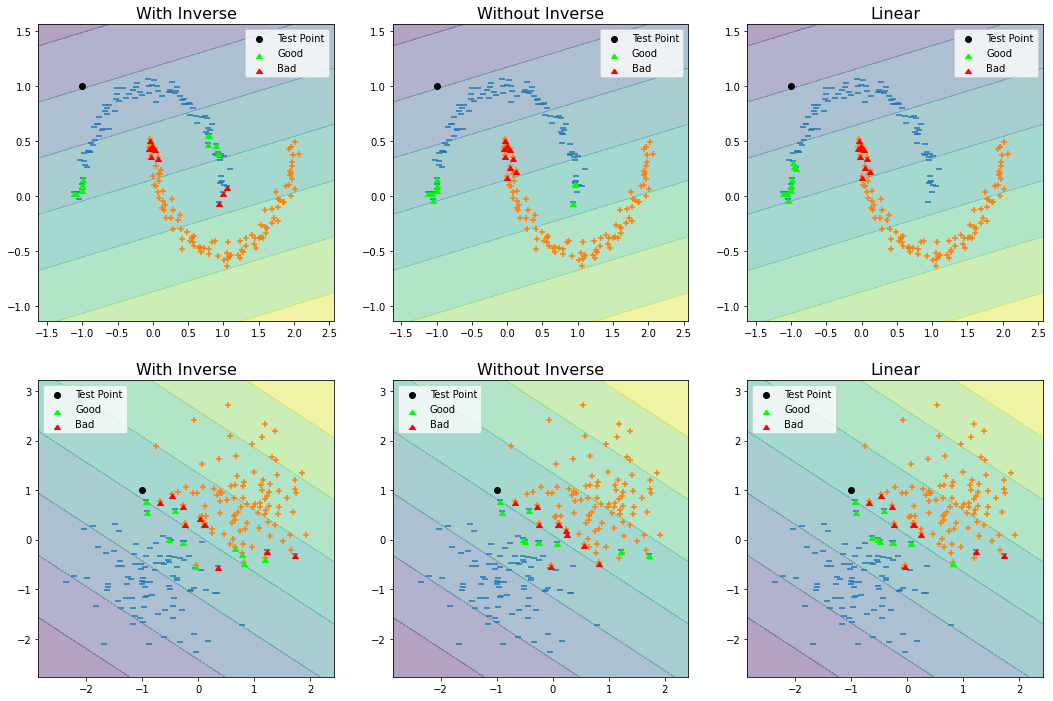

In [ ]:
fig = plt.figure(figsize=(len(influence_types) * 6, len(data) * 6))

for i, data_type in enumerate(data.keys()):
    x, y = data[data_type]["x"], data[data_type]["y"]
    x_test, y_test = test_points[data_type]["x"], test_points[data_type]["y"]
    xx, yy, Z = xxs[data_type], yys[data_type], Zs[data_type]

    for j, influence_type in enumerate(influence_types):
        ax = fig.add_subplot(len(data), len(influence_types), (i) * len(influence_types) + (j + 1))
        ax.contourf(xx, yy, Z, alpha=0.4)
        ax.scatter(x[:, 0][y == 0], x[:, 1][y == 0], marker="_")
        ax.scatter(x[:, 0][y == 1], x[:, 1][y == 1], marker="+")
        ax.scatter(x_test[0], x_test[1], c="black", label="Test Point")
        ax.scatter(x[influential_points[data_type][influence_type][-10:], 0], x[influential_points[data_type][influence_type][-10:], 1], c="lime", marker=6, label="Good")
        ax.scatter(x[influential_points[data_type][influence_type][:10], 0], x[influential_points[data_type][influence_type][:10], 1], c="red", marker=6, label="Bad")
        ax.set_title(title_mapping[influence_type], size=16)
        ax.legend()


In [ ]:
s_tests["moon"]["orig"]

DeviceArray([-0.0589666 ,  0.31078315, -0.02102268], dtype=float32)

## Comparison With Conjugate Gradient

In our above computation of $s_{\mathrm{test}}$, we naively computed the full Hessian, and explicitly inverted the matrix. Here we look at using CG to compute the HIVP

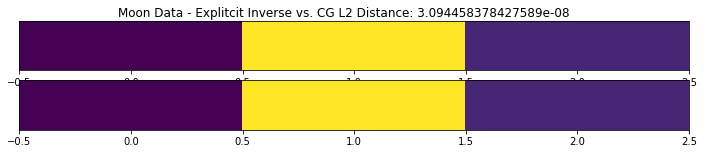

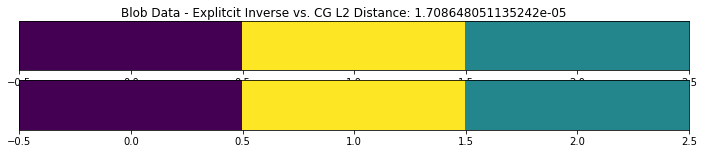

In [ ]:
for data_type in hessians.keys():
    s_test_cg = jax.scipy.sparse.linalg.cg(hessians[data_type], vs[data_type])[0]
    s_test_orig = s_tests[data_type]["orig"]

    difference = onp.linalg.norm(s_test_orig - s_test_cg, ord=2)

    fig = plt.figure(figsize=(12, 2))

    ax = fig.add_subplot(211)
    ax.imshow(s_test_cg[onp.newaxis], aspect="auto")
    ax.set_yticks([])

    ax = fig.add_subplot(212)
    ax.imshow(s_test_orig[onp.newaxis], aspect="auto")
    ax.set_yticks([])

    fig.suptitle("{} Data - Explitcit Inverse vs. CG L2 Distance: {}".format(data_type.capitalize(), difference))

# Retrain Without Important Points

In [ ]:
def fit(x, y):
    set_seed(2)

    loss_grad = jax.jit(jax.vmap(jax.value_and_grad(stable_loss), in_axes=(None, 0, 0), out_axes=0))
    lr = 10
    params = initialize_params()
    epochs = 2000

    for epoch in range(epochs):
        values, grads = loss_grad(params, new_x, new_y)
        params = [param - lr * np.mean(grad, axis=0) for param, grad in zip(params, grads)]

        if np.mean(values) < 0.01:
            break
        if epoch % 1000 == 0:
            print("Loss: {}".format(np.mean(values)))

    return params

In [ ]:
num_points = 10

In [ ]:
actual_diffs = {data_type: [] for data_type in data.keys()}

for data_type in data.keys():
    print("Now training on {} dataset".format(data_type))
    x, y = data[data_type]["x"], data[data_type]["y"]

    for i in range(num_points):
        idx = influential_points[data_type]["orig"][i]

        new_x, new_y = np.concatenate([x[:idx], x[idx + 1:]]), np.concatenate([y[:idx], y[idx + 1:]])

        temp_params = fit(x, y)

        temp_loss = stable_loss(temp_params, x_test, y_test)
        actual_diffs[data_type].append(temp_loss - test_losses[data_type])

Now training on moon dataset
Loss: 1.3625568151474
Loss: 0.2488795518875122
Loss: 1.3625158071517944
Loss: 0.2501811385154724
Loss: 1.3626012802124023
Loss: 0.25081032514572144
Loss: 1.362554669380188
Loss: 0.2508745491504669
Loss: 1.3624532222747803
Loss: 0.2514931857585907
Loss: 1.373535394668579
Loss: 0.24857425689697266
Loss: 1.3625788688659668
Loss: 0.2526770234107971
Loss: 1.3623855113983154
Loss: 0.25366950035095215
Loss: 1.373545527458191
Loss: 0.25065547227859497
Loss: 1.3735569715499878
Loss: 0.2517548203468323
Now training on blob dataset
Loss: 1.3783328533172607
Loss: 0.07244827598333359
Loss: 1.3782707452774048
Loss: 0.08137621730566025
Loss: 1.3683708906173706
Loss: 0.09699743986129761
Loss: 1.3676846027374268
Loss: 0.09589052945375443
Loss: 1.3676601648330688
Loss: 0.09806381165981293
Loss: 1.3679511547088623
Loss: 0.09825947135686874
Loss: 1.3670626878738403
Loss: 0.09768425673246384
Loss: 1.3671404123306274
Loss: 0.09798942506313324
Loss: 1.378117322921753
Loss: 0.0978

In [ ]:
actual_diffs = {data_type: onp.array(actual_diffs[data_type]) for data_type in actual_diffs.keys()}
pred_diffs_orig = {data_type: onp.array(influences[data_type]["orig"][influential_points[data_type]["orig"][:num_points]]) for data_type in actual_diffs.keys()}
pred_diffs_no_inv = {data_type: onp.array(influences[data_type]["no_inv"][influential_points[data_type]["no_inv"][:num_points]]) for data_type in actual_diffs.keys()}

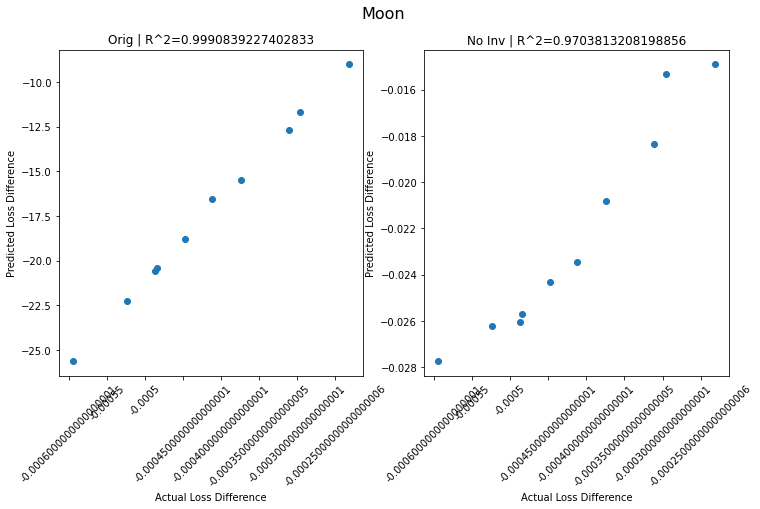

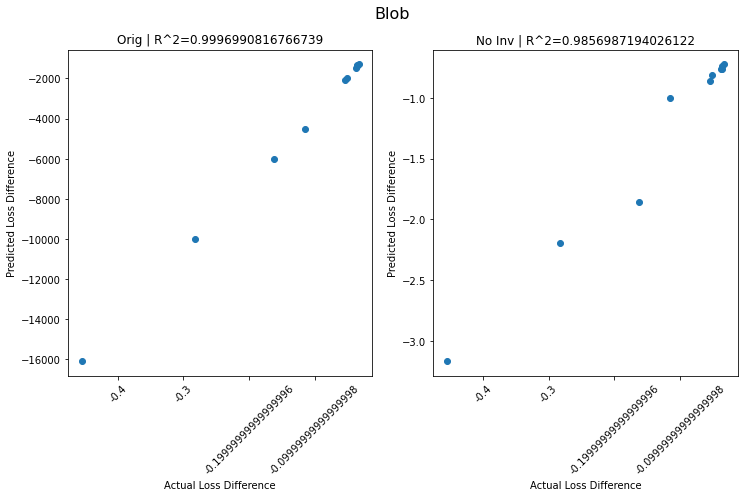

In [ ]:
for data_type in actual_diffs.keys():
    actual_diff = actual_diffs[data_type]
    pred_diff_orig = pred_diffs_orig[data_type]
    pred_diff_no_inv = pred_diffs_no_inv[data_type]

    r2_orig = pearsonr(actual_diff, pred_diff_orig)[0]
    r2_no_inv = pearsonr(actual_diff, pred_diff_no_inv)[0]

    fig = plt.figure(figsize=(12,6))

    ax = fig.add_subplot(121)
    ax.scatter(actual_diff, pred_diff_orig)
    ax.set_xlabel("Actual Loss Difference")
    ax.set_ylabel("Predicted Loss Difference")
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
    ax.set_title("Orig | R^2={}".format(r2_orig))

    ax = fig.add_subplot(122)
    ax.scatter(actual_diff, pred_diff_no_inv)
    ax.set_xlabel("Actual Loss Difference")
    ax.set_ylabel("Predicted Loss Difference")
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
    ax.set_title("No Inv | R^2={}".format(r2_no_inv))


    fig.suptitle("{}".format(data_type.capitalize()), size=16)

    plt.show()

# Identify Noisy Samples

Let's create a noisy version of the data used to fit the model previously. To do so, we randomly flip a certain percentage of the labels.

## Generate Noisy Data

In [ ]:
set_seed(2)
x_blob, y_blob = create_blobs_data(200)
x_moon, y_moon = create_moons_data(200, noise=0.1)

data_noisy = {"moon": {"x": x_moon, "y_clean": y_moon},
             "blob": {"x": x_blob, "y_clean": y_blob}}

In [ ]:
noise = 0.2

In [ ]:
for data_type in data_noisy.keys():
    y_noisy = data_noisy[data_type]["y_clean"].copy()
    x = data_noisy[data_type]["x"]

    noisy_indices = onp.random.choice(onp.arange(len(x)).astype(int), int(noise * len(x)), replace=False)
    y_noisy[noisy_indices] = 1 - y_noisy[noisy_indices]
    data_noisy[data_type]["y_noisy"] = y_noisy

## Train Model

In [ ]:
loss_grad = jax.jit(jax.vmap(jax.value_and_grad(stable_loss), in_axes=(None, 0, 0), out_axes=0))
lr = 0.1
params_noisy = {data_type: initialize_params() for data_type in data_noisy.keys()}
epochs = 2000

In [ ]:
for data_type in data_noisy.keys():
    print("Now training on {} dataset".format(data_type))
    x, y = data_noisy[data_type]["x"], data_noisy[data_type]["y_noisy"]

    for epoch in range(epochs):
        values, grads = loss_grad(params_noisy[data_type], x, y)

        if np.any(np.isnan(values)):
            print("One of the loss values is NaN. Stopping optimization")
            break
        params_noisy[data_type] = [param - lr * np.mean(grad, axis=0) for param, grad in zip(params_noisy[data_type], grads)]

        if np.mean(values) < 0.05:
            break
        if epoch % 1000 == 0:
            print("Loss: {}".format(np.mean(values)))

Now training on moon dataset
Loss: 1.2443196773529053
Loss: 0.5541428327560425
Now training on blob dataset
Loss: 1.3629833459854126
Loss: 0.5434058308601379


## Compute Losses

Like in the paper, we look at using loss to rank mislabeled samples as a baseline

In [ ]:
losses_noisy = {data_type: [] for data_type in data_noisy.keys()}

for data_type in data_noisy.keys():
    x, y = data_noisy[data_type]["x"], data_noisy[data_type]["y_noisy"]

    for i in range(len(x)):
        x_i, y_i = x[i], y[i]
        temp_loss = stable_loss(params_noisy[data_type], x_i, y_i)
        losses_noisy[data_type].append(temp_loss)

In [ ]:
losses_noisy = {data_type: onp.array(losses_noisy[data_type]) for data_type in losses_noisy.keys()}

In [ ]:
influential_points_loss = {data_type: onp.argsort(losses_noisy[data_type])[::-1] for data_type in losses_noisy.keys()}

## Compute Influences


In [ ]:
flattened_params_noisy = {data_type: {"params": ravel_pytree(params_noisy[data_type])[0],
                                "unflattener": ravel_pytree(params_noisy[data_type])[1]} for data_type in params_noisy.keys()}

In [ ]:
train_losses_noisy = {data_type: 0.0 for data_type in data_noisy.keys()}
hessians_noisy = {data_type: None for data_type in data_noisy.keys()}
inv_hessians_noisy = {data_type: None for data_type in data_noisy.keys()}

for data_type in data_noisy.keys():
    flat_params, unflattener = flattened_params_noisy[data_type]["params"], flattened_params_noisy[data_type]["unflattener"]
    x, y = data_noisy[data_type]["x"], data_noisy[data_type]["y_noisy"]

    train_loss = empirical_risk(flat_params, unflattener, x, y)
    hess = jax.hessian(empirical_risk)(flat_params, unflattener, x, y)
    inv_hess = onp.linalg.inv(hess)

    train_losses_noisy[data_type] = train_loss
    hessians_noisy[data_type] = hess
    inv_hessians_noisy[data_type] = inv_hess

In [ ]:
influence_types = ["orig", "no_inv", "linear"]
influences_noisy = {data_type: {influence_type: [0.0] * len(data_noisy[data_type]["x"]) for influence_type in influence_types} for data_type in data_noisy.keys()}

for data_type in data_noisy.keys():
    flat_params, unflattener = flattened_params_noisy[data_type]["params"], flattened_params_noisy[data_type]["unflattener"]
    x, y = data_noisy[data_type]["x"], data_noisy[data_type]["y_noisy"]

    for i in range(len(x)):
        grad_x_i = jax.grad(flat_loss)(flat_params, unflattener, x[i], y[i])

        influences_noisy[data_type]["orig"][i] = - onp.vdot(onp.sum(inv_hessians_noisy[data_type] * grad_x_i, axis=1), grad_x_i)
        influences_noisy[data_type]["no_inv"][i] = - onp.vdot(onp.sum(hessians_noisy[data_type] * grad_x_i, axis=1), grad_x_i)
        influences_noisy[data_type]["linear"][i] = -onp.vdot(grad_x_i, grad_x_i)

In [ ]:
influences_noisy = {data_type: {influence_type: np.array(influences_noisy[data_type][influence_type]) *
                          (-1.0 * len(influences_noisy[data_type][influence_type])) for influence_type in influence_types} for data_type in influences_noisy.keys()}

In [ ]:
influential_points_noisy = {data_type: {influence_type: onp.array(np.argsort(influences_noisy[data_type][influence_type])) for influence_type in influence_types} for data_type in influences_noisy.keys()}

In [ ]:
for data_type in influential_points_noisy.keys():
    influential_points_noisy[data_type]["loss"] = influential_points_loss[data_type]

## Visualize Noisy Points

In [ ]:
xxs, yys = {}, {}
Zs = {}

In [ ]:
for data_type in data_noisy.keys():
    x, y = data_noisy[data_type]["x"], data_noisy[data_type]["y_noisy"]
    x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
    y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5
    xx, yy = onp.meshgrid(onp.arange(x_min, x_max, 0.01),
                            onp.arange(y_min, y_max, 0.01))

    temp = jax.vmap(network, in_axes=(None, 0), out_axes=0)

    Z = temp(params_noisy[data_type], onp.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    xxs[data_type] = xx
    yys[data_type] = yy
    Zs[data_type] = Z

In [ ]:
title_mapping = {"orig": "With Inverse", "no_inv": "Without Inverse", "linear": "Linear", "loss": "Loss"}

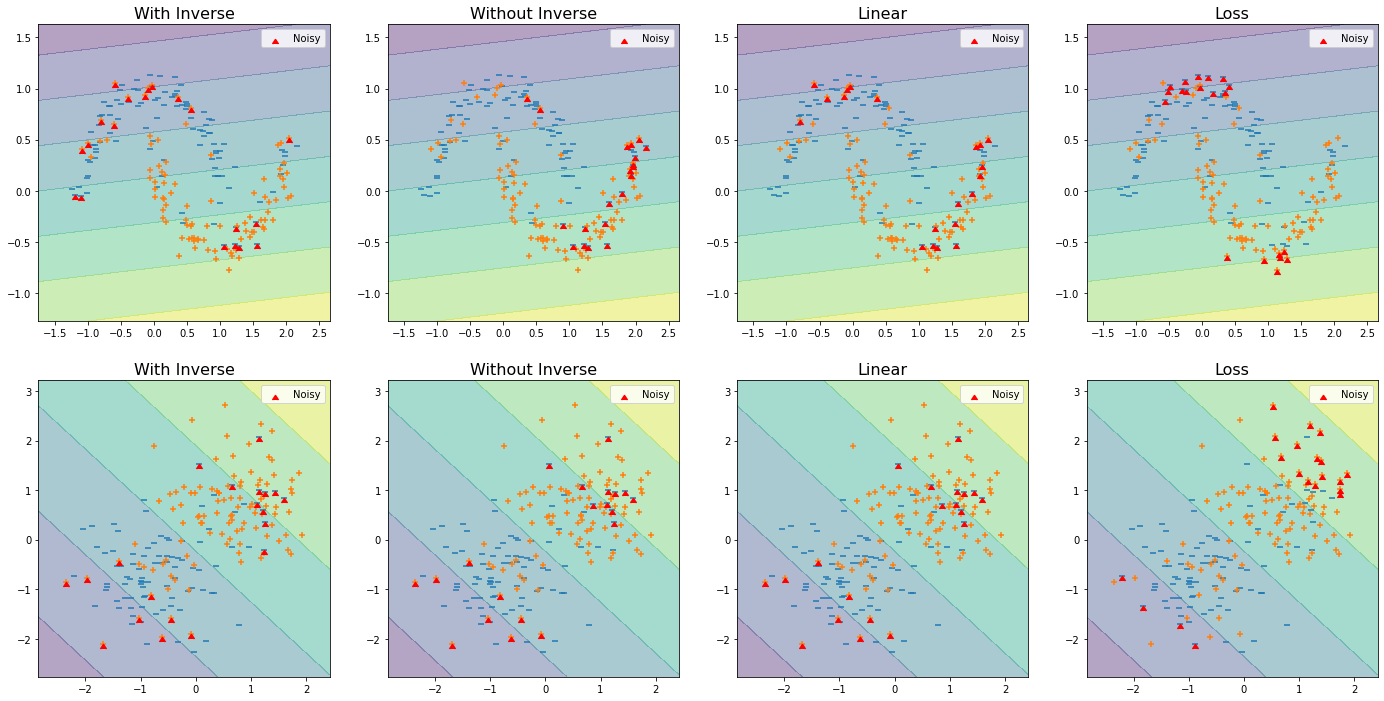

In [ ]:
fig = plt.figure(figsize=(len(title_mapping) * 6, len(data_noisy) * 6))

for i, data_type in enumerate(data_noisy.keys()):
    x, y = data_noisy[data_type]["x"], data_noisy[data_type]["y_noisy"]
    xx, yy, Z = xxs[data_type], yys[data_type], Zs[data_type]

    for j, influence_type in enumerate(influential_points_noisy[data_type].keys()):
        ax = fig.add_subplot(len(data_noisy), len(title_mapping), (i) * len(title_mapping) + (j + 1))
        ax.contourf(xx, yy, Z, alpha=0.4)
        ax.scatter(x[:, 0][y == 0], x[:, 1][y == 0], marker="_")
        ax.scatter(x[:, 0][y == 1], x[:, 1][y == 1], marker="+")

        ax.scatter(x[influential_points_noisy[data_type][influence_type][-20:], 0], x[influential_points_noisy[data_type][influence_type][-20:], 1], c="red", marker=6, label="Noisy")
        ax.set_title(title_mapping[influence_type], size=16)
        ax.legend()